In [1]:
import osmnx as ox
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from shapely import LineString, Polygon, intersection, Point, MultiLineString, GeometryCollection
import numpy as np
import random

# Load and Clean the Data

In [2]:
G_original = ox.load_graphml('Tokyo_street_network.graphml')

In [3]:
debug = True

# For Tokyo, debug
min_lat, max_lat = 35.683743, 35.700187
min_lon, max_lon = 139.755065, 139.777357

# For No boundaries
# min_lat, max_lat = -360.0, 360.0
# min_lon, max_lon = -360.0, 360.0

In [4]:
nodes_of_interest = {}
for node, data in tqdm(G_original.nodes(data=True), desc="Data Cleaning"):
    if min_lat <= data['y'] <= max_lat and min_lon <= data['x'] <= max_lon:
        degree = G_original.degree[node]
        if degree != 2:
            # only keep x and y attributes for each node
            data = {"x": data['x'], "y": data['y'], "degree": degree}
            nodes_of_interest[node] = data

G = G_original.subgraph(nodes_of_interest).copy()
del G_original

Data Cleaning: 100%|██████████| 279734/279734 [00:00<00:00, 8704896.21it/s]


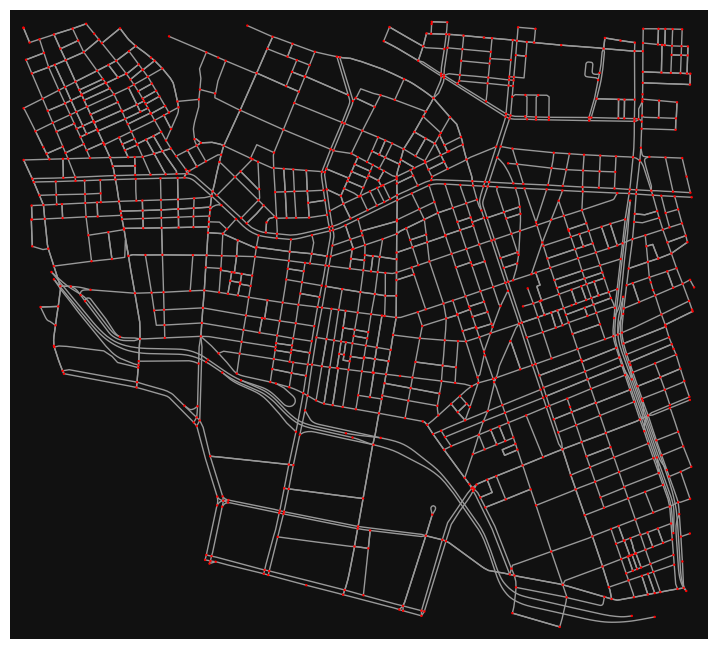

In [5]:
if debug:
    fig, ax = ox.plot_graph(G, node_size=3, edge_linewidth=1, figsize=(9, 9), node_color="red")

# Detecting Degree-2 Keynodes 

In [6]:
def calculate_angle(p1, p2, p3):
    """Calculate the angle (in degrees) between points n1, n2, and n3."""
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    
    # Vector from n2 to n1
    v1 = (x1 - x2, y1 - y2)
    # Vector from n2 to n3
    v2 = (x3 - x2, y3 - y2)
    
    # Calculate the angle using the dot product formula
    dot_product = v1[0] * v2[0] + v1[1] * v2[1]
    mag_v1 = math.sqrt(v1[0]**2 + v1[1]**2)
    mag_v2 = math.sqrt(v2[0]**2 + v2[1]**2)
    cos_theta = max(-1, min(1, dot_product / (mag_v1 * mag_v2)))
    angle_rad = math.acos(cos_theta)
    
    # Convert radians to degrees
    return math.degrees(angle_rad)

In [7]:
uid = 0
G_new = G.copy()
for u, v, data in tqdm(G.edges(data=True), desc="Filtering edges within bounding box"):
    if "geometry" in data:
        points = list(data["geometry"].coords)
        last_node = u
        next_node = v
        for i in range(1, len(points) - 1):
            angle = calculate_angle(points[i - 1], points[i], points[i + 1])
            if angle < 90:
                new_node = f"i{uid}"
                uid += 1
                G_new.add_node(new_node, x=points[i][0], y=points[i][1], degree=2)

                # Add (last_node, new_node) and (new_node, next_node) edges
                geom_u_i =  LineString(data["geometry"].coords[:i+1])
                geom_i_v = LineString(data["geometry"].coords[i:])
                G_new.add_edge(last_node, new_node, geometry=geom_u_i)
                G_new.add_edge(new_node, next_node, geometry=geom_i_v)
                # Remove the original edge
                G_new.remove_edge(last_node, next_node)
                
                last_node = new_node

G = G_new.copy()
del G_new

Filtering edges within bounding box: 100%|██████████| 2512/2512 [00:00<00:00, 228301.01it/s]


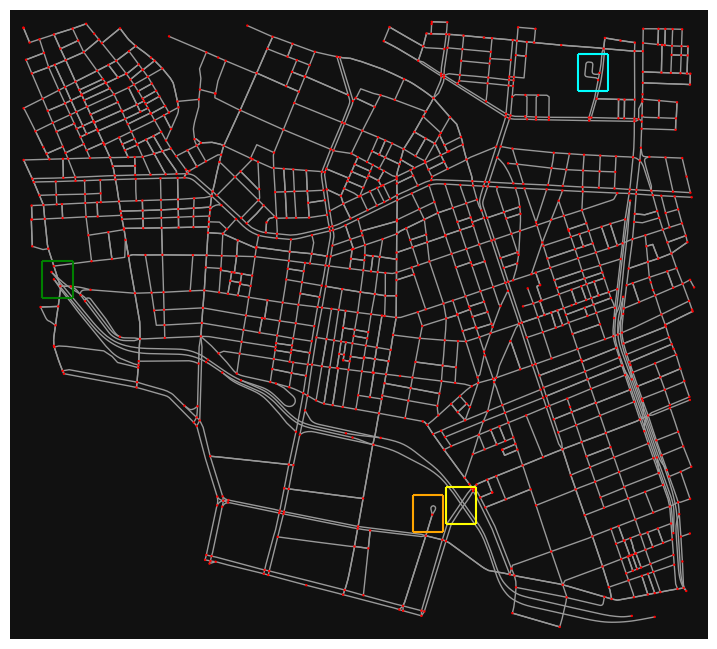

In [48]:
if debug:
    fig, ax = ox.plot_graph(G, node_size=3, edge_linewidth=1, figsize=(9, 9), node_color="red", show=False)
    # bot, top, left, right
    bboxes = [
        [35.6983, 35.6993, 139.7735, 139.7745],
        [35.6866, 35.6876, 139.7691, 139.7701],
        [35.6927, 35.6937, 139.7557, 139.7567],
        [35.6864, 35.6874, 139.7680, 139.7690]
    ]
    colors = ["cyan", "yellow", "green", "orange"]
    for i in range(len(bboxes)):
        bbox = bboxes[i]
        color = colors[i]
        plt.hlines(bbox[:2], *bbox[2:], color=color)
        plt.vlines(bbox[2:], *bbox[:2], color=color)

# Subgraph and Map Extraction

In [49]:
interp_n = 8
base_interp_dists = np.linspace(0, 1, interp_n)
interp_func = lambda line_string : LineString([line_string.interpolate(d) for d in base_interp_dists * line_string.length])

# 0.0012 lat, lon box is around 250 m^2

# default = 0.0012, 0.0012, 10000
lat_range = 0.0009
lon_range = 0.0009
data_count = 4

In [50]:
# randomly select data_count nodes from the graph
src_nodes = np.random.choice(list(G.nodes()), data_count, replace=False)

# Get a subgraph containing all nodes within the bounding box
sub_graphs = []
graph_bboxes = []
max_n_edges = 0
for src_node in tqdm(src_nodes, desc="Creating subgraphs"):
    if src_node[0] != 'i':
        src_node = int(src_node)
    # Compute the bounding box for this subgraph
    node_lat, node_lon = G.nodes[src_node]["y"], G.nodes[src_node]["x"]

    lat_bot, lat_top = node_lat - lat_range, node_lat + lat_range
    lon_left, lon_right = node_lon - lon_range, node_lon + lon_range
    lat_bot, lat_top, lon_left, lon_right = bboxes[len(sub_graphs)]
    bbox = Polygon([(lon_left, lat_top), (lon_right, lat_top), (lon_right, lat_bot), (lon_left, lat_bot)])

    graph_bboxes.append((lat_bot, lat_top, lon_left, lon_right))

    sub_graph = nx.MultiGraph()
    cut_uid = 0
    for u in G.nodes():

        ux, uy = G.nodes[u]["x"], G.nodes[u]["y"]

        # If the distance between u and src_node is greater than 4 * lat_range, skip
        # if (ux - node_lon)**2 + (uy - node_lat)**2 > 8 * lat_range**2:
        #     continue

        for v in G.neighbors(u):
            vx, vy = G.nodes[v]["x"], G.nodes[v]["y"]
            for data in G.get_edge_data(u, v).values():
                
                # intersection will return a LineString containing the segment inside the bbox
                if "geometry" in data:
                    geometry = data["geometry"]
                else:
                    geometry = LineString([(ux, uy), (vx, vy)])

                inter_segments = intersection(bbox, geometry)

                if inter_segments.is_empty:
                    inter_segments = []
                elif isinstance(inter_segments, LineString) or isinstance(inter_segments, GeometryCollection):
                    inter_segments = [inter_segments]
                elif isinstance(inter_segments, MultiLineString):
                    inter_segments = list(inter_segments.geoms)
                elif isinstance(inter_segments, Point):
                    inter_segments = []
                else:
                    raise ValueError(f"Unexpected type {type(inter_segments)}")

                try:
                    for intersect_segment in inter_segments:
                        if intersect_segment.coords[0] != geometry.coords[0]:
                            u_new = f"cut{cut_uid}"
                            cut_uid += 1
                        else:
                            u_new = u
    
                        if intersect_segment.coords[-1] != geometry.coords[-1]:
                            v_new = f"cut{cut_uid}"
                            cut_uid += 1
                        else:
                            v_new = v
    
                        sub_graph.add_node(u_new, x=intersect_segment.coords[0][0], y=intersect_segment.coords[0][1])
                        sub_graph.add_node(v_new, x=intersect_segment.coords[-1][0], y=intersect_segment.coords[-1][1])
                        sub_graph.add_edge(u_new, v_new, geometry=interp_func(intersect_segment))
                except:
                    print("Error occured, skip node")

    sub_graph.graph["crs"] = G.graph["crs"]
    if len(sub_graph.nodes()) == 0:
        print("Empty subgraph, skip")
    else:
        sub_graphs.append(sub_graph)

    max_n_edges = max(max_n_edges, sub_graph.number_of_edges())

all_segs = np.zeros((data_count, max_n_edges, interp_n, 2))
for b, graph in enumerate(sub_graphs):
    for i, (u, v, data) in enumerate(graph.edges(data=True)):
        all_segs[b, i] = np.array(data["geometry"].coords)

np.save("all_segs.npy", all_segs)
np.save("graph_bboxes.npy", graph_bboxes)

Creating subgraphs: 100%|██████████| 4/4 [00:00<00:00, 51.00it/s]


(35.6983, 35.6993, 139.7735, 139.7745)
(35.6866, 35.6876, 139.7691, 139.7701)
(35.6864, 35.6874, 139.768, 139.769)
(35.6927, 35.6937, 139.7557, 139.7567)
(35.6864, 35.6874, 139.768, 139.769)
(35.6983, 35.6993, 139.7735, 139.7745)
(35.6864, 35.6874, 139.768, 139.769)
(35.6864, 35.6874, 139.768, 139.769)
(35.6927, 35.6937, 139.7557, 139.7567)


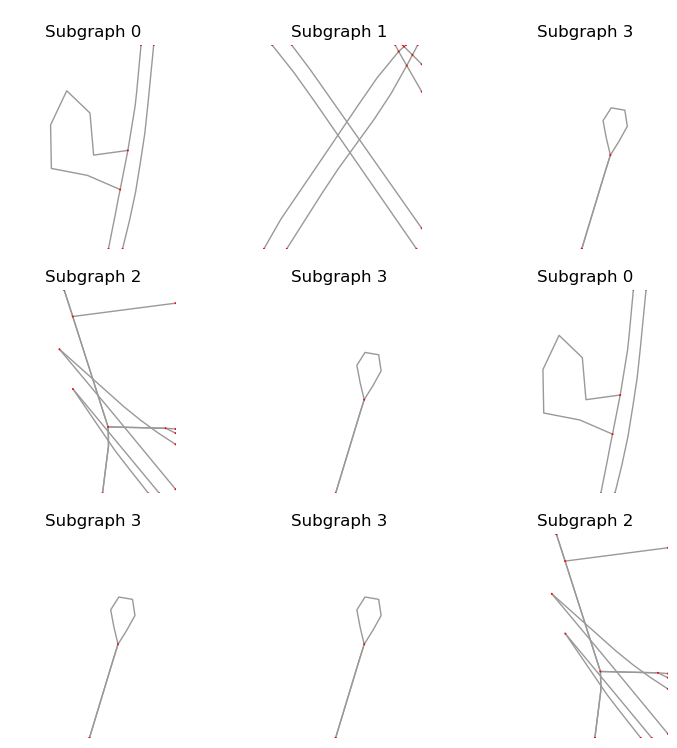

In [52]:
# Draw 9 subgraphs
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    for j in range(3):
        idx = random.randint(0, len(sub_graphs) - 1)
        ax = axs[i, j]
        ax.set_title(f"Subgraph {idx}")
        print(graph_bboxes[idx])
        ox.plot_graph(sub_graphs[idx], node_size=2, edge_linewidth=1, ax=ax, show=False, node_color="red")
        ax.set_xlim((graph_bboxes[idx][2], graph_bboxes[idx][3]))
        ax.set_ylim((graph_bboxes[idx][0], graph_bboxes[idx][1]))

plt.show()

# Generate Routes and Trajectories

In [53]:
N_trajs = 48
max_visited_num = 8
min_traj_len = 15
max_traj_len = 16
# default = 0.00002
noise_std = 0.00000   # medium

In [54]:
def myLineMerge(geom_list):
    # Used for concatenating multiple LineString (head-tail, head-head, tail-tail or tail-head)
    result = list(geom_list[0].coords)
    for geom in geom_list[1:]:
        if result[-1] == geom.coords[0]:
            result += list(geom.coords[1:])
        elif result[-1] == geom.coords[-1]:
            result += list(geom.coords[::-1][1:])
        elif result[0] == geom.coords[0]:
            result = list(geom.coords[::-1]) + result[1:]
        elif result[0] == geom.coords[-1]:
            result = list(geom.coords) + result[1:]
    return LineString(result)

100%|██████████| 4/4 [00:00<00:00, 94.47it/s]


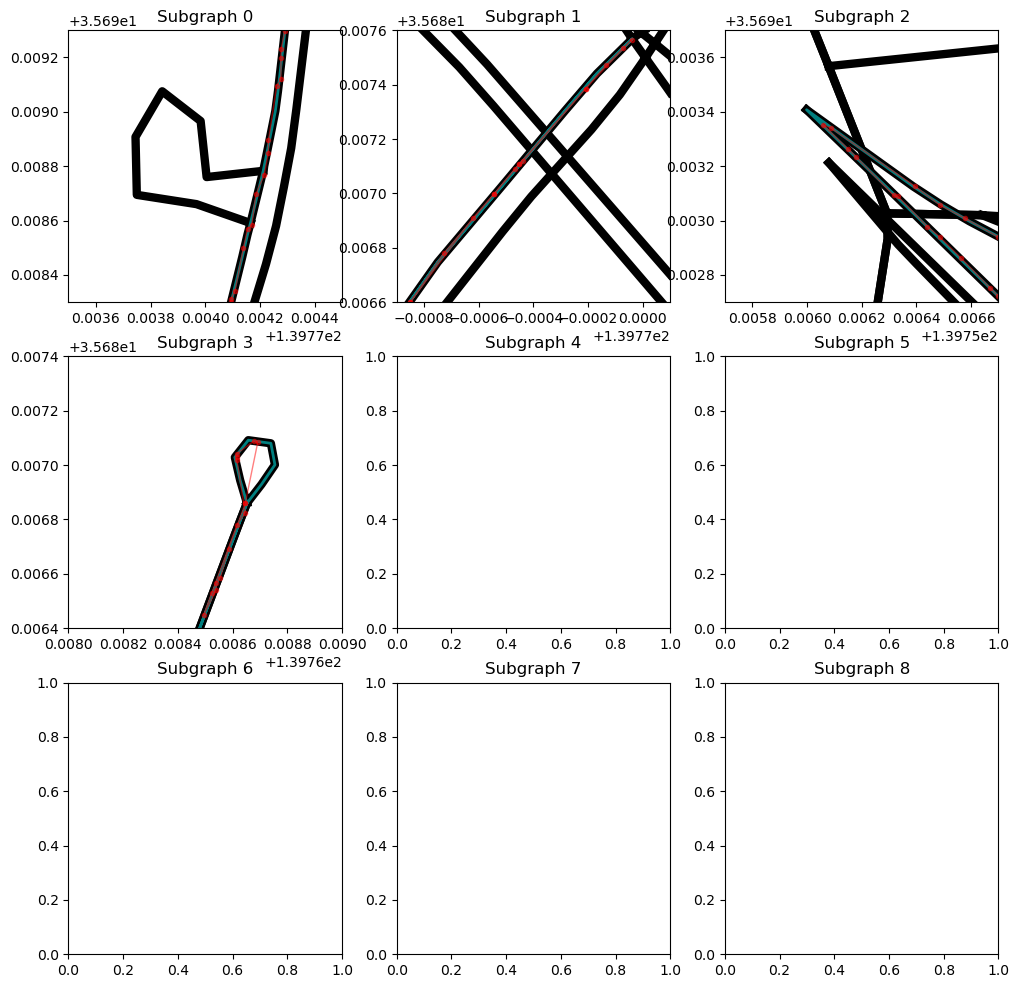

In [57]:
all_routes = np.zeros((data_count, N_trajs, max_visited_num, interp_n, 2), np.float32)
all_trajs = np.zeros((data_count, N_trajs, max_traj_len, 2), np.float32)

all_traj_lens = np.random.randint(min_traj_len, max_traj_len, (data_count, N_trajs))

if debug:
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for i in range(3):
        for j in range(3):
            try:
                idx = i * 3 + j
                axes[i, j].set_title(f"Subgraph {idx}")
                axes[i, j].set_xlim((graph_bboxes[idx][2], graph_bboxes[idx][3]))
                axes[i, j].set_ylim((graph_bboxes[idx][0], graph_bboxes[idx][1]))
                for seg in all_segs[idx]:
                    axes[i, j].plot(seg[:, 0], seg[:, 1], color="black", linewidth=6)
            except:
                continue

pbar = tqdm(sub_graphs)
for b, graph in enumerate(pbar):
    edges = [(u, v, data) for u, v, data in graph.edges(data=True)]
    edges_weight = np.array([data["geometry"].length for u, v, data in edges])
    edges_weight /= edges_weight.sum()
    unvisited_edges = [(u, v) for u, v in graph.edges()]
    for i in range(N_trajs):
        # first, make sure each node is chosen at least once
        if len(unvisited_edges) != 0:
            start_edge = unvisited_edges.pop()
        else:
            edge_id = int(np.random.choice(range(len(edges)), p=edges_weight))
            start_edge = edges[edge_id]
        
        visit_nodes = [start_edge[0], start_edge[1]]

        # random walk
        visit_geoms = [graph.get_edge_data(visit_nodes[0], visit_nodes[1])[0]["geometry"]]
        for j in range(1, max_visited_num):
            neighbors = list(graph.neighbors(visit_nodes[-1]))
            if len(neighbors) <= 1:
                visit_nodes = visit_nodes[::-1]     # flip
                visit_geoms = visit_geoms[::-1]     # flip
                # Lets's try to explore the other direction
                neighbors = list(graph.neighbors(visit_nodes[-1]))
                if len(neighbors) <= 1:
                    break

            # choose unvisited edge first
            for neighbor in neighbors:
                if (visit_nodes[-1], neighbor) in unvisited_edges or (neighbor, visit_nodes[-1]) in unvisited_edges:
                    next_node = neighbor
                    break
            else:
                prev_node = visit_nodes[-2]
                go_back_id = neighbors.index(prev_node)
                # longer distance, larger weight
                weight = np.array([graph.get_edge_data(visit_nodes[-1], v)[0]["geometry"].length for v in neighbors])
                weight[go_back_id] *= 0.1
                next_node_id = int(np.random.choice(range(len(neighbors)), p=weight / weight.sum()))
                next_node = neighbors[next_node_id]

            visit_nodes.append(next_node)
            edge_data = list(graph.get_edge_data(visit_nodes[-2], visit_nodes[-1]).values())
            visit_geoms.append(random.choice(edge_data)["geometry"])

            if len(unvisited_edges) != 0:
                if (visit_nodes[-2], visit_nodes[-1]) in unvisited_edges:
                    unvisited_edges.remove((visit_nodes[-2], visit_nodes[-1]))
                elif (visit_nodes[-1], visit_nodes[-2]) in unvisited_edges:
                    unvisited_edges.remove((visit_nodes[-1], visit_nodes[-2]))

        # Merge geometries
        # route = ops.linemerge(visit_geoms)
        visit_points = myLineMerge(visit_geoms)

        # pbar.set_postfix_str(f"RouteLen={len(route.coords)}, VisitNum={len(visit_geoms)}")

        # interp_distances = np.linspace(0, visit_points.length, all_traj_lens[b, i])
        interp_distances = np.sort(np.concatenate([
            np.linspace(0, visit_points.length, 6),
            np.random.uniform(0, visit_points.length, all_traj_lens[b, i] - 6)
        ]))
        interp_points = [visit_points.interpolate(d) for d in interp_distances]

        traj = np.array([p.coords[0] for p in interp_points])
        traj += np.random.normal(0, noise_std, traj.shape)

        all_routes[b, i, :len(visit_geoms), :] = np.stack([np.array(geom.coords) for geom in visit_geoms], axis=0)
        all_trajs[b, i, :all_traj_lens[b, i], :] = traj

    # plot route
    if debug and  b < 9:
        row = b // 3
        col = b % 3
        axes[row, col].plot(*visit_points.xy, color="cyan", linewidth=2, alpha=0.5)
        # plot trajectory
        axes[row, col].plot(all_trajs[b, i, :all_traj_lens[b, i], 0], all_trajs[b, i, :all_traj_lens[b, i], 1], 
                            color="red", linewidth=1, alpha=0.5, marker=".")

    if len(unvisited_edges) != 0:
        print(f"Warning! {len(unvisited_edges)} edges are not visited!")
        fig, ax = ox.plot_graph(sub_graphs[b], node_size=2, edge_linewidth=1, show=False, node_color="red", figsize=(4, 4))
        ax.set_xlim((graph_bboxes[b][2], graph_bboxes[b][3]))
        ax.set_ylim((graph_bboxes[b][0], graph_bboxes[b][1]))
        for k in range(N_trajs):
            plt.plot(all_trajs[b, k, :all_traj_lens[idx, k], 0], 
                     all_trajs[b, k, :all_traj_lens[idx, k], 1], alpha=0.7, marker=".", linewidth=1)
        plt.show()

np.save("all_routes.npy", all_routes)
np.save("all_trajs.npy", all_trajs)

if debug:
    plt.show()

IndexError: index 4 is out of bounds for axis 0 with size 4

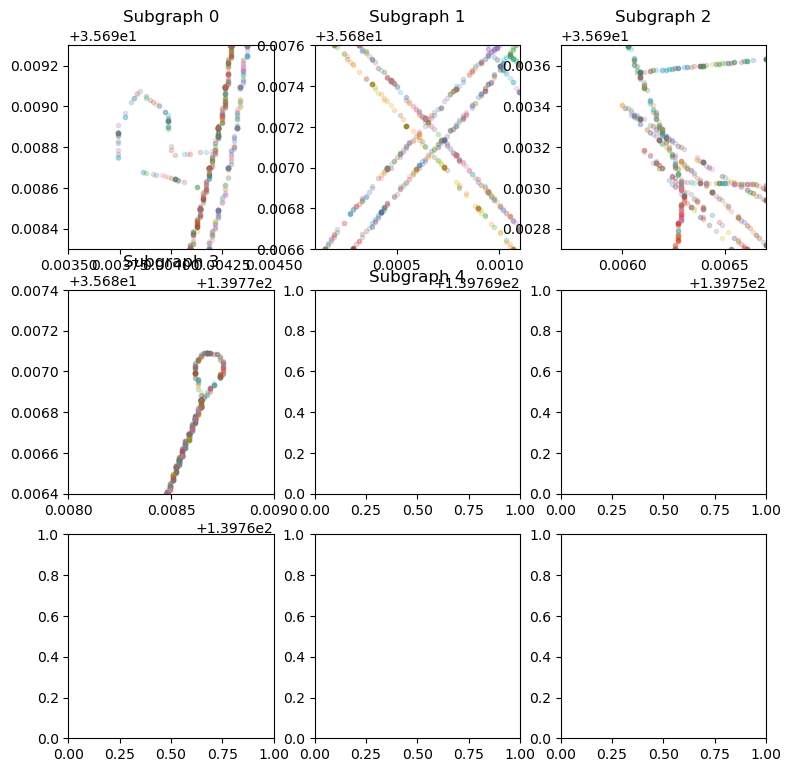

In [58]:
# Draw 9 subgraphs
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        ax = axs[i, j]
        ax.set_title(f"Subgraph {idx}")
        for k in range(N_trajs):
            ax.scatter(all_trajs[idx, k, :all_traj_lens[idx, k], 0], 
                    all_trajs[idx, k, :all_traj_lens[idx, k], 1], alpha=0.2, marker=".")#, linewidth=1)
        ax.set_xlim((graph_bboxes[idx][2], graph_bboxes[idx][3]))
        ax.set_ylim((graph_bboxes[idx][0], graph_bboxes[idx][1]))

plt.show()